In [1]:
import gym
import numpy as np

from utils_min import plot_learning_curve
from Custom_functions import CustomEnv5, CustomEnv2, CustomEnv6
import os
import matplotlib.pyplot as plt
from td3_min import Agent
from td3_min import ReplayBuffer
from stable_baselines3.common.env_checker import check_env

In [6]:
env = CustomEnv2(t_steps = 10, seed = 2, nx=3, ny=1)

In [7]:
check_env(env)

In [14]:
observation = env.reset()
done = False
i = 0
while not done:
	i += 1
	action = env.action_space.sample()
	#perform action
	observation_, reward, done, info = env.step(action)
	print("current yaw is:", env.yaw_current[0], "the action was", action[0], "reward is:", reward, "wd is:", env.wd)
	




current yaw is: -10.3714 the action was 0.83308846 reward is: 1.0145009530721707 wd is: 270.0
current yaw is: -11.191066 the action was -0.81966555 reward is: 1.015924132383169 wd is: 270.0
current yaw is: -11.693351 the action was -0.502285 reward is: 1.0186296242686461 wd is: 270.0
current yaw is: -11.613287 the action was 0.0800642 reward is: 1.0181930334888463 wd is: 270.0
current yaw is: -11.798396 the action was -0.18510923 reward is: 1.0187884858340024 wd is: 270.0
current yaw is: -11.59555 the action was 0.20284612 reward is: 1.0196596045546644 wd is: 270.0
current yaw is: -11.051848 the action was 0.5437012 reward is: 1.0190793548189676 wd is: 270.0
current yaw is: -10.2869215 the action was 0.76492673 reward is: 1.0165594298008538 wd is: 270.0
current yaw is: -9.996503 the action was 0.29041836 reward is: 1.0153134816052884 wd is: 270.0
current yaw is: -9.10945 the action was 0.8870523 reward is: 1.0153467077325347 wd is: 270.0
current yaw is: -8.492455 the action was 0.61699

In [23]:
SEED = 4
FOLDER = "models/TD3_test_custenv4_1/TD3_"

In [24]:
env = CustomEnv4(t_steps = 100, seed = SEED)

In [25]:
agent = Agent(alpha=0.001, beta=0.001, 
            input_dims=env.observation_space.shape[0], tau=0.005,
            env=env, layer1_size=400, layer2_size=300,
            gamma=0.99, update_actor_interval=2,
            n_actions=env.action_space.shape[0], seed=SEED ,folder=FOLDER,
            policy_noise = 0.2, noise_clip = 0.5)

In [26]:
replay_buffer = ReplayBuffer(state_dim = env.observation_space.shape[0], action_dim = env.action_space.shape[0], max_size=int(1e6))

In [27]:
expl_noise = 0.2
action_dim = env.action_space.shape[0]

n_games = 550
warm_up_games = 50
best_score = env.reward_range[0]
best_avg = env.reward_range[0]
score_history = []
batch_size = 256

n_averaging = 50

for i in range(n_games):
	observation = env.reset()
	done = False
	score = 0
	while not done:

		#Choose an action:
		#if i < warmup, do a random step.
		if i < warm_up_games:
			action = env.action_space.sample()
		else:
			action = np.clip(agent.choose_action(observation) + np.random.normal(0, expl_noise, size=action_dim), -1, 1)
			expl_noise = expl_noise*0.99

		#perform action
		observation_, reward, done, info = env.step(action)

		#Store in replay buffer 
		replay_buffer.add(observation, action, observation_, reward, float(done))

		if i >= warm_up_games: #If warmup is done, perform learning
			agent.learn(replay_buffer, batch_size)


		score += reward
		observation = observation_

	score_history.append(score)
	avg_score = np.mean(score_history[-n_averaging:])

	if avg_score > best_avg and i > warm_up_games:
		print("best avg, saving")
		best_avg = avg_score
		agent.save(FOLDER, "avg_best")

	if score > best_score and i > warm_up_games:
		print("new pr, saving")
		best_score = score
		agent.save(FOLDER, "best")
	
	print('episode ', i, '| score %.2f' % score,
		'| trailing ', n_averaging,  ' games avg %.3f' % avg_score, '| best score is: %.3f' % best_score)
	
	

episode  0 | score 102.31 | trailing  50  games avg 102.310 | best score is: -inf
episode  1 | score 102.70 | trailing  50  games avg 102.506 | best score is: -inf
episode  2 | score 104.01 | trailing  50  games avg 103.006 | best score is: -inf
episode  3 | score 105.13 | trailing  50  games avg 103.536 | best score is: -inf
episode  4 | score 102.09 | trailing  50  games avg 103.247 | best score is: -inf
episode  5 | score 100.38 | trailing  50  games avg 102.769 | best score is: -inf
episode  6 | score 101.07 | trailing  50  games avg 102.527 | best score is: -inf
episode  7 | score 99.71 | trailing  50  games avg 102.175 | best score is: -inf
episode  8 | score 99.14 | trailing  50  games avg 101.837 | best score is: -inf
episode  9 | score 103.52 | trailing  50  games avg 102.006 | best score is: -inf
episode  10 | score 100.66 | trailing  50  games avg 101.883 | best score is: -inf
episode  11 | score 99.89 | trailing  50  games avg 101.717 | best score is: -inf
episode  12 | sco

In [28]:
filename = 'Floris_' + str(n_games) + 'games.png'
figure_file = FOLDER  + filename


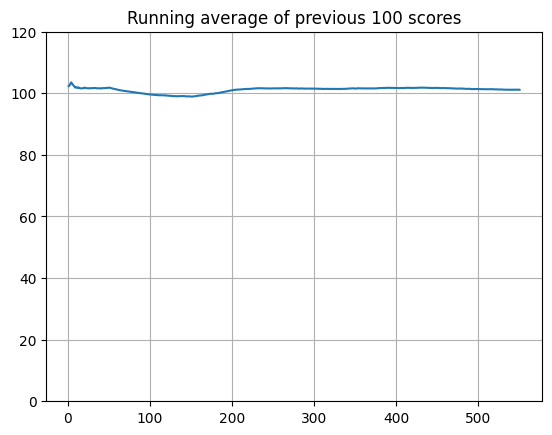

In [29]:
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, score_history, figure_file, ylim=[0, 120])

In [27]:
np.savetxt(FOLDER+"score.csv", score_history, delimiter=',')

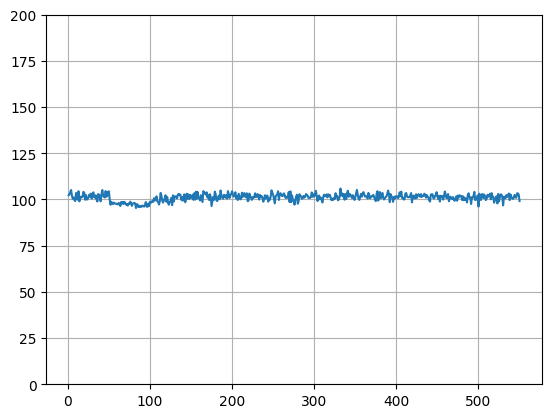

In [31]:
plt.plot(x, score_history)
plt.grid()
plt.ylim((0, 200))
plt.show()

In [14]:
#Load the best performing model
agent.load(FOLDER, "best")

In [31]:
observation

array([ 0.75555557, -0.44444445, -0.3       ,  0.08919799, -1.        ,
        1.        ,  1.        ,  1.        ,  0.75855076,  0.71536994,
       -0.7956888 , -1.        ], dtype=float32)

In [32]:
action_list = []
reward_list = []
wd_list = []

observation = env.reset()
done = False
score = 0
while not done:
    action = agent.choose_action(observation)
    observation_, reward, done, info = env.step(action)
    #agent.remember(observation, action, reward, observation_, done)
    #agent.learn()
    #score += reward
    reward_list.append(reward)
    wd_list.append(env.wd)
    print(env.wd)
    print("obs er:", observation[0])

    observation = observation_


print("done")
reward_list = np.array(reward_list)
wd_list = np.array(wd_list)


270.0
obs er: 0.5
270.0
obs er: 0.5
270.0
obs er: 0.5
270.0
obs er: 0.5
270.0
obs er: 0.5
270.0
obs er: 0.5
270.0
obs er: 0.5
270.0
obs er: 0.5
270.0
obs er: 0.5
270.0
obs er: 0.5
270.0
obs er: 0.5
270.0
obs er: 0.5
270.0
obs er: 0.5
270.0
obs er: 0.5
271.0
obs er: 0.5
272.0
obs er: 0.50555557
273.0
obs er: 0.51111114
274.0
obs er: 0.51666665
275.0
obs er: 0.5222222
276.0
obs er: 0.5277778
277.0
obs er: 0.53333336
278.0
obs er: 0.5388889
279.0
obs er: 0.54444444
280.0
obs er: 0.55
281.0
obs er: 0.5555556
282.0
obs er: 0.5611111
283.0
obs er: 0.56666666
284.0
obs er: 0.57222223
285.0
obs er: 0.5777778
286.0
obs er: 0.5833333
287.0
obs er: 0.5888889
288.0
obs er: 0.59444445
289.0
obs er: 0.6
290.0
obs er: 0.60555553
291.0
obs er: 0.6111111
292.0
obs er: 0.6166667
293.0
obs er: 0.62222224
294.0
obs er: 0.62777776
295.0
obs er: 0.6333333
296.0
obs er: 0.6388889
297.0
obs er: 0.64444447
298.0
obs er: 0.65
299.0
obs er: 0.65555555
300.0
obs er: 0.6611111
301.0
obs er: 0.6666667
302.0
obs er:

In [33]:
len(wd_list)

101

In [35]:
wd_list[0:10]

array([316., 316., 316., 316., 316., 316., 316., 316., 316., 316.],
      dtype=float32)

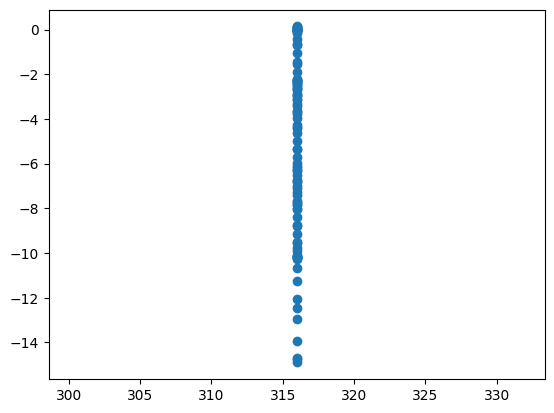

In [16]:
plt.scatter(wd_list, reward_list)
plt.show()

In [5]:
import numpy as np

In [6]:
A = np.zeros(9, dtype=np.float32)
B = np.array(10)
C = np.array(0.5)

In [16]:
np.concatenate((B, C, A), axis = None)

array([10. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
      dtype=float32)

In [1]:
from Custom_functions import CustomEnv8, CustomEnv9
import numpy as np
from stable_baselines3.common.env_checker import check_env

In [4]:
env = CustomEnv9(t_steps = 20)

In [5]:
check_env(env)

In [4]:
np.arange(270, 360, 15)

array([270, 285, 300, 315, 330, 345])

In [21]:
obs = env.reset()
print(obs)

[0.]


In [5]:
obs

array([1.], dtype=float32)

In [4]:
env.step(env.action_space.sample())

in reset:
[1.0222223]


(array([1.0222223], dtype=float32), 0.02164100432569427, False, {})

In [6]:
obs.shape

(1,)

In [14]:
test = np.zeros(shape=(1,))

In [15]:
test.shape

(1,)

In [22]:
np.array((2)).astype(np.float32).shape

()

In [8]:
A + 2

array([2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=float32)

In [16]:
def testfun(x):
    A = 3
    A_last = 3
    print("A is: ", A)
    print("A_last is: ", A_last)
    A = 22
    print("changing A")
    print("A is: ", A)
    print("A_last is: ", A_last)
    A_last = A
    print("changing A_last")
    print("A is: ", A)
    print("A_last is: ", A_last)
    A = 222
    print("changing A")
    print("A is: ", A)
    print("A_last is: ", A_last)

In [17]:
testfun(1)

A is:  3
A_last is:  3
changing A
A is:  22
A_last is:  3
changing A_last
A is:  22
A_last is:  22
changing A
A is:  222
A_last is:  22


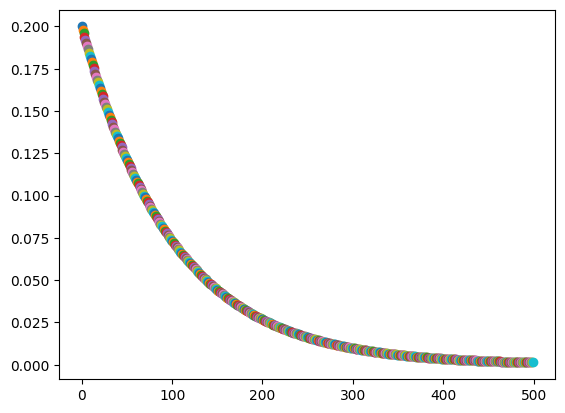

In [21]:
test_val = []
noise = 0.2

for i in range(500):
    plt.scatter(i,noise)
    noise = noise * 0.99

plt.show()

1

In [4]:
import numpy as np

In [27]:
A = (1)

In [48]:
A

1

In [76]:
np.random.choice((10, 15)).astype(np.float32)

10.0

In [1]:
import numpy as np

In [2]:
A = (10, 15, 20, 30)

In [4]:
max(A), min(A)

(30, 10)

In [17]:
np.random.choice(A)

10